## Načtení dat ##

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ddf = (pd.read_csv('edinburgh_bikes.csv').drop(['Unnamed: 0', 'index'], axis=1))

ddf[['started_at', 'ended_at']] = (
    ddf[['started_at', 'ended_at']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S'))

ddf['duration'] = ddf['duration'].apply(lambda x: x/60)  # minutes
ddf.rename(columns={'duration': 'duration_min'}, inplace=True)

## Popis datového souboru ##

In [57]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438259 entries, 0 to 438258
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   started_at                 438259 non-null  datetime64[ns]
 1   ended_at                   438259 non-null  datetime64[ns]
 2   duration_min               438259 non-null  float64       
 3   start_station_id           438259 non-null  int64         
 4   start_station_name         438259 non-null  object        
 5   start_station_description  434118 non-null  object        
 6   start_station_latitude     438259 non-null  float64       
 7   start_station_longitude    438259 non-null  float64       
 8   end_station_id             438259 non-null  int64         
 9   end_station_name           438259 non-null  object        
 10  end_station_description    433570 non-null  object        
 11  end_station_latitude       438259 non-null  float64 

In [58]:
# first and last record - timeframe
ddf.sort_values('started_at').iloc[[0,-1],[0,1]]

,started_at,ended_at
0,2018-09-15 08:52:05,2018-09-15 09:11:48
438258,2021-06-30 23:58:33,2021-07-01 00:07:15


In [59]:
ddf.head(3)

,started_at,ended_at,duration_min,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05,2018-09-15 09:11:48,19.700000,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15 09:24:33,2018-09-15 09:41:09,16.583333,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15 09:48:54,2018-09-15 10:46:40,57.766667,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116


### Chybějící hodnoty ###
- pouze popisky stanic 

In [60]:
ddf.isna().any()

started_at                   False
ended_at                     False
duration_min                 False
start_station_id             False
start_station_name           False
start_station_description     True
start_station_latitude       False
start_station_longitude      False
end_station_id               False
end_station_name             False
end_station_description       True
end_station_latitude         False
end_station_longitude        False
dtype: bool

### Odlehlé hodnoty ###
- trvání výpůjčky (duration)

In [61]:
round(ddf[['duration_min']]
 .describe(percentiles=[.05, .25, .50, .75, .95, .99])
 .drop('count'), 1).T

,mean,std,min,5%,25%,50%,75%,95%,99%,max
duration_min,32.5,94.3,1.0,4.6,10.4,19.4,42.2,90.2,186.5,39389.1


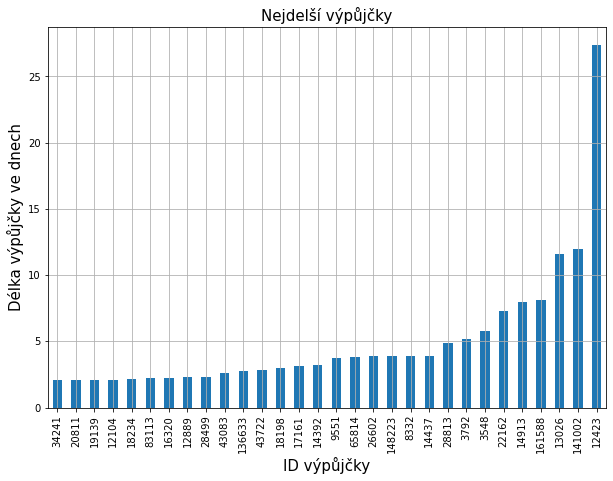

In [62]:
fig, ax = plt.subplots(figsize=(10,7))

# in days
(ddf[['duration_min']]/60/24).sort_values('duration_min').tail(30).plot.bar(ax=ax)

ax.set_title('Nejdelší výpůjčky', fontsize=15)
ax.set_xlabel('ID výpůjčky', fontsize=15)
ax.set_ylabel('Délka výpůjčky ve dnech', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

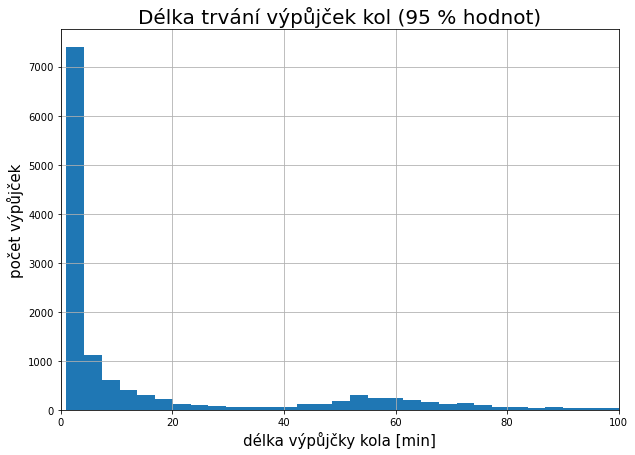

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist((ddf['duration_min']).value_counts(), bins=100)

ax.set_xlim(0, 100)
ax.set_title('Délka trvání výpůjček kol (95 % hodnot)', fontsize=20)
ax.set_xlabel('délka výpůjčky kola [min]', fontsize=15)
ax.set_ylabel('počet výpůjček', fontsize=15)
ax.grid()
plt.show()

## Aktivní a neaktivní stanice ##

In [64]:
# List of all stations
s1 = (ddf[['start_station_id', 'start_station_name']]
      .rename(columns={'start_station_id': 'station_ID',
                       'start_station_name': 'station_name'}))
s2 = (ddf[['end_station_id', 'end_station_name']]
      .rename(columns={'end_station_id': 'station_ID',
                       'end_station_name': 'station_name'}))
stations_df = (s1.append(s2)
               .drop_duplicates(subset='station_ID')
               .set_index('station_ID')
               .sort_index())

In [65]:
stations_df.head(3)

,station_name
station_ID,
171,George Square
183,Waverley Bridge
189,City Chambers


In [66]:
activity_df = (stations_df
               .assign(departures_count = ddf.groupby('start_station_id')
                       .count()[['started_at']])
               .assign(arrivals_count = ddf.groupby('end_station_id')
                       .count()[['ended_at']])
               .fillna(0)
               .astype({'departures_count': int, 'arrivals_count': int}))
activity_df['total_count'] = (activity_df['departures_count']
                              + activity_df['arrivals_count'])
activity_df = (activity_df.sort_values('total_count'))
 
activity_df.tail(3)

,station_name,departures_count,arrivals_count,total_count
station_ID,,,,
250,Victoria Quay,10662,15254,25916
1728,Portobello - Kings Road,11843,16656,28499
265,Meadows East,17390,15225,32615


In [67]:
round(activity_df[['total_count']]
 .describe(percentiles=[.05, .10, .25, .50, .75, .90, .95, .99]),0).astype(int).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
total_count,200,4383,5682,1,13,65,442,2171,5972,11053,16353,25942,32615


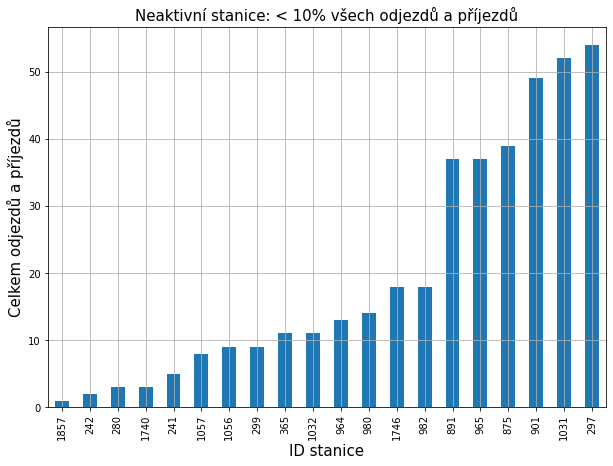

In [68]:
# lowest 10% - inactive
fig, ax = plt.subplots(figsize=(10,7))
activity_df[['total_count']].query('total_count < 64.8').plot.bar(ax=ax)

ax.set_title('Neaktivní stanice: < 10% všech odjezdů a příjezdů', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Celkem odjezdů a příjezdů', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

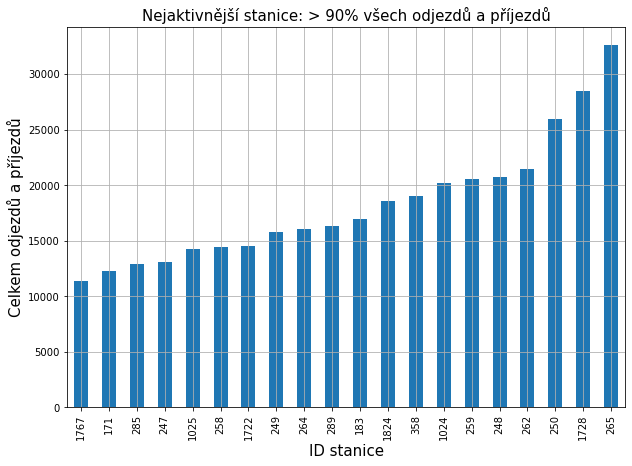

In [69]:
# highest 10% - most active
fig, ax = plt.subplots(figsize=(10,7))
activity_df[['total_count']].query('total_count > 11053').plot.bar(ax=ax)

ax.set_title('Nejaktivnější stanice: > 90% všech odjezdů a příjezdů', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Celkem odjezdů a příjezdů', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

## Kde se kola hromadí a kde naopak chybí ##
- Víc příjezdů než odjezdů a naopak

In [431]:
activity_df.tail(3)

,station_name,departures_count,arrivals_count,total_count
station_ID,,,,
250,Victoria Quay,10662,15254,25916
1728,Portobello - Kings Road,11843,16656,28499
265,Meadows East,17390,15225,32615


In [432]:
# bike increase per station
increase_df = (
    activity_df[activity_df['arrivals_count'] > activity_df['departures_count']]
    .iloc[:, [0,3]]
    .assign(increase = activity_df['arrivals_count'] - activity_df['departures_count'])
    .sort_values('increase', ascending=False)
)
increase_df.head(3)

,station_name,total_count,increase
station_ID,,,
1728,Portobello - Kings Road,28499,4813
250,Victoria Quay,25916,4592
1824,Duke Street,18552,3976


In [433]:
# bike decrease per station
decrease_df = (
    activity_df[activity_df['arrivals_count'] < activity_df['departures_count']]
    .iloc[:, [0,3]]
    .assign(decrease = activity_df['departures_count'] - activity_df['arrivals_count'])
    .sort_values('decrease', ascending=False)
)
decrease_df.head(3)

,station_name,total_count,decrease
station_ID,,,
248,Bristo Square,20744,4948
259,St Andrew Square,20590,3846
247,Charlotte Square,13114,3154


In [434]:
# time difference between first and last record for each station

# bike increase (arrivals):
df = pd.DataFrame()
for i in increase_df.index:
    last = (ddf.query(f'end_station_id == {i}')[['ended_at']]
            .sort_values('ended_at').iloc[-1])
    first = (ddf.query(f'end_station_id == {i}')[['ended_at']]
             .sort_values('ended_at').iloc[0])
    row_df = (pd.DataFrame({'interval_days': (last[0]-first[0]).total_seconds()
                            /3600/24}, index=[i]))
    df = df.append(row_df)
    
# bike decrease (departures):
for i in decrease_df.index:
    last = (ddf.query(f'start_station_id == {i}')[['started_at']]
            .sort_values('started_at').iloc[-1])
    first = (ddf.query(f'start_station_id == {i}')[['started_at']]
             .sort_values('started_at').iloc[0])
    row_df = (pd.DataFrame({'interval_days': (last[0]-first[0]).total_seconds()
                            /3600/24}, index=[i]))
    df = df.append(row_df)    

In [435]:
increase_df = increase_df.join(df)
decrease_df = decrease_df.join(df)

In [436]:
increase_df['incr_per_day'] = increase_df.increase / increase_df.interval_days
increase_df = (increase_df.sort_values('incr_per_day', ascending=False)
                    .round(2))

In [437]:
decrease_df['decr_per_day'] = decrease_df.decrease / decrease_df.interval_days
decrease_df = (decrease_df.sort_values('decr_per_day', ascending=False)
               .round(2))

In [438]:
# filter criteria for bike increments
increase_df = increase_df.query('interval_days > 30 and incr_per_day > 1')
increase_df.head(3)

,station_name,total_count,increase,interval_days,incr_per_day
station_ID,,,,,
1728,Portobello - Kings Road,28499,4813,615.47,7.82
1824,Duke Street,18552,3976,510.23,7.79
820,Newkirkgate,3768,894,123.94,7.21


In [439]:
# filter criteria for bike decrements
decrease_df = decrease_df.query('interval_days > 30 and decr_per_day > 1')
decrease_df.head(3)

,station_name,total_count,decrease,interval_days,decr_per_day
station_ID,,,,,
248,Bristo Square,20744,4948,1017.41,4.86
1767,Bruntsfield Links,11373,2629,566.01,4.64
259,St Andrew Square,20590,3846,1019.46,3.77


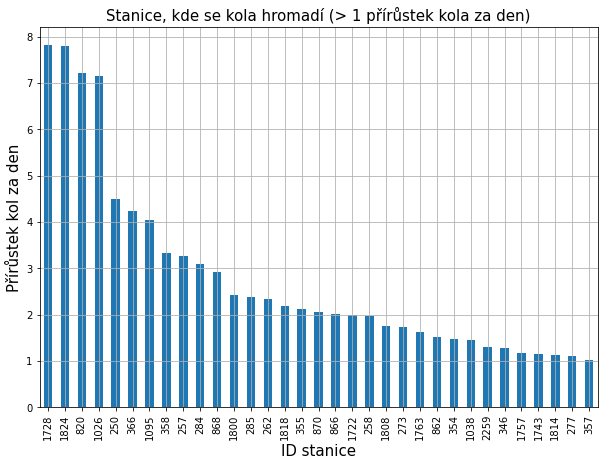

In [443]:
# interval_days > 30 and incr_per_day > 1
fig, ax = plt.subplots(figsize=(10,7))
increase_df.incr_per_day.plot.bar(ax=ax)
 
ax.set_title('Stanice, kde se kola hromadí (> 1 přírůstek kola za den)', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Přírůstek kol za den', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

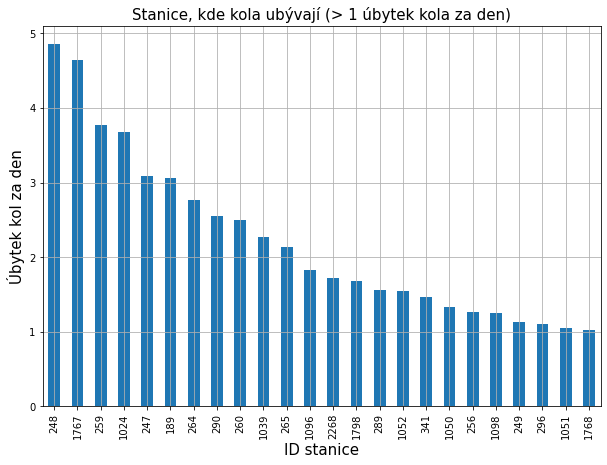

In [444]:
# interval_days > 30 and decr_per_day > 1
fig, ax = plt.subplots(figsize=(10,7))
decrease_df.decr_per_day.plot.bar(ax=ax)
 
ax.set_title('Stanice, kde kola ubývají (> 1 úbytek kola za den)', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Úbytek kol za den', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

In [446]:
ddf.head(3)

,started_at,ended_at,duration_min,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05,2018-09-15 09:11:48,19.700000,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15 09:24:33,2018-09-15 09:41:09,16.583333,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15 09:48:54,2018-09-15 10:46:40,57.766667,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116


In [559]:
stations_df.head(3)

,station_name
station_ID,
171,George Square
183,Waverley Bridge
189,City Chambers


In [560]:
stations_df.count()

station_name    200
dtype: int64

In [570]:
df1 = (ddf[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
 .rename(columns={'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'})
 .set_index('start_station_id')
 .drop_duplicates())
df1.count()

latitude     221
longitude    221
dtype: int64

In [587]:
# duplicate coordinates for station IDs
duplicate_id_mask = df1.index.duplicated()
duplicate_id = df1.index[duplicate_id_mask]
    # small differences - will be averaged
#(df1.loc[duplicate_id].sort_index().groupby('start_station_id').diff().dropna()*1000).round(10)

In [592]:
df1 = df1.groupby('start_station_id').mean()
df1.head(3)

,latitude,longitude
start_station_id,,
171,55.943084,-3.188311
183,55.951663,-3.191656
189,55.950109,-3.190258


In [594]:
df2 = (ddf[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
 .rename(columns={'end_station_latitude': 'latitude', 'end_station_longitude': 'longitude'})
 .set_index('end_station_id')
 .drop_duplicates())

In [599]:
# duplicate coordinates for station IDs
duplicate_id_mask = df2.index.duplicated()
duplicate_id = df2.index[duplicate_id_mask]
    # small differences - will be averaged
#(df2.loc[duplicate_id].sort_index().groupby('end_station_id').diff().dropna()*1000).round(10)

In [600]:
df2 = df2.groupby('end_station_id').mean()
df2.head(3)

,latitude,longitude
end_station_id,,
171,55.943084,-3.188311
183,55.951663,-3.191656
189,55.950109,-3.190258


In [607]:
df1.append(df2).drop_duplicates()

,latitude,longitude
171,55.943084,-3.188311
183,55.951663,-3.191656
189,55.950109,-3.190258
225,55.951734,-3.184179
241,55.972373,-3.155833
...,...,...
2265,55.943985,-3.058400
2268,55.956535,-3.186248
242,55.972402,-3.155794
259,55.954794,-3.192623


## Vývoj poptávky po půjčování kol v čase ##

In [795]:
df1 = ddf[['started_at']]
df1.head(3)

,started_at
0,2018-09-15 08:52:05
1,2018-09-15 09:24:33
2,2018-09-15 09:48:54


In [796]:
df1 = df1.groupby(df1['started_at'].dt.date).count()

In [797]:
# number of departures for each day
df1.index.name = 'date'
df1.rename(columns={'started_at': 'count'}, inplace=True)
df1 = df1.sort_index()
df1.head(3)

,count
date,
2018-09-15,3
2018-09-16,10
2018-09-17,403


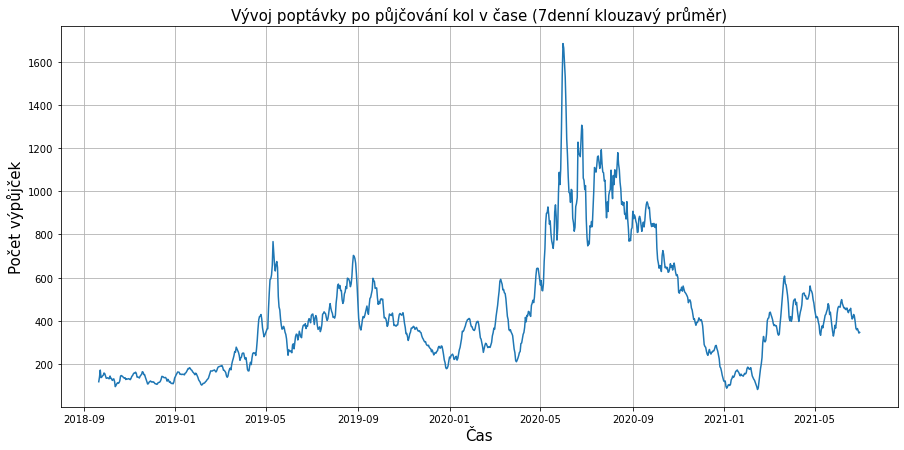

In [802]:
# rolling 7-day mean
fig, ax = plt.subplots(figsize=(15,7))
df1.rolling(7).mean().plot(ax=ax)
 
ax.set_title('Vývoj poptávky po půjčování kol v čase (7denní klouzavý průměr)', fontsize=15)
ax.set_xlabel('Čas', fontsize=15)
ax.set_ylabel('Počet výpůjček', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

In [799]:
df2 = ddf[['started_at']]
df2 = df2.groupby(df2['started_at'].dt.weekday).count()

# number of departures for each weekday (Monday=0, Sunday=6)
df2.index.name = 'weekday'
df2.rename(columns={'started_at': 'count'}, inplace=True)
df2.rename(index={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}, inplace=True)
df2

,count
weekday,
Monday,57949
Tuesday,58662
Wednesday,59605
Thursday,60809
Friday,63339
Saturday,70865
Sunday,67030


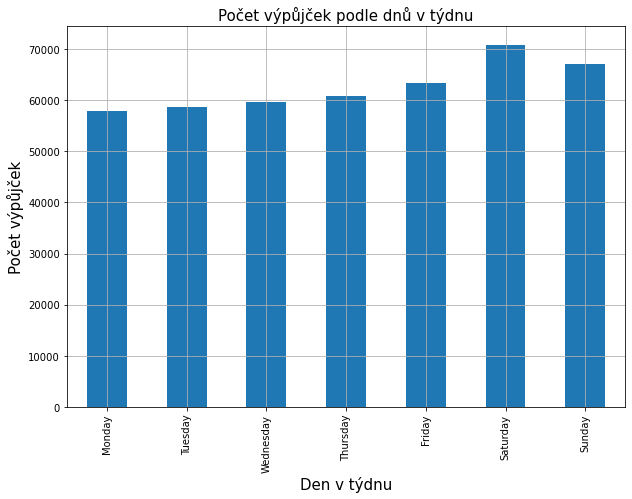

In [800]:
fig, ax = plt.subplots(figsize=(10,7))
df2.plot.bar(ax=ax)
 
ax.set_title('Počet výpůjček podle dnů v týdnu', fontsize=15)
ax.set_xlabel('Den v týdnu', fontsize=15)
ax.set_ylabel('Počet výpůjček', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

## Vliv počasí na poptávku po kolech ##